# Topic Modelling: Intro
Topic Modelling is a form of unsupervised learning that aims to find topic clusters in a series of texts. We will be using LDA, which is one of the most popular forms of doing Topic Modelling



First we do all our imports then download the data that has been preprocessed

In [1]:
import scipy
import gensim
from gensim import corpora
import pandas as pd

In [2]:
letters = pd.read_csv('data/preprocessed_letters.csv')

In [3]:
#ask harry to change the csv column name
print(letters.columns)

Index(['Unnamed: 0', 'letter', 'year'], dtype='object')


Extract all the letters and their keys into two separate lists

In [4]:
letterkeys = list(letters['Unnamed: 0'])
lettervalues = list(letters["letter"])
#get the letters

The way the preprocessed letters have been stored has removed the tokenization. We can simply split each letter into its own list of tokens once again.

In [5]:
#split into tokens
splitletters = []
for letter in lettervalues:
    splitletters.append(letter.split())

From now on, we will be working with these split letter values

There are some words that appear excessively

In [7]:
# List of words to remove
words_to_remove = {"get", "go", "one", "david", "may", "good", "letter", "think", "send", "day", "time", "come", "take", "1917", "well", "say", "tell", "write", "two"
,"know","much","would","make", "could", "would"}

# Remove unwanted words
filtered = [
    [word for word in sublist if word not in words_to_remove]
    for sublist in splitletters
]



# N grams and Nouns and Adjectives
You get "cleaner" n-grams focused on meaningful content words.
Note: part of this code was copied from or modified from this tutorial: https://tomvannuenen.medium.com/analyzing-reddit-communities-with-python-part-5-topic-modeling-a5b0d119add, along with referencing code from the "Clustering_TopicModelling" notebook.

we will have to doadditoanl proceessing, as this is differnet from what the other members are doign smth


oroiganlly the topic modelling was ivignvery poor scores udner 0.4, which is bad. we want it to be betwen 0.4 and 0.6 which would be great
The following code was copied from the tutorial linked

i did: removed a bunch of common words and got it from .38 to 44
did bigrams and trigrams 44 to 48

In [89]:
bigram = gensim.models.Phrases(filtered, min_count=5, threshold=300)
trigram = gensim.models.Phrases(bigram[filtered], threshold=300)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [90]:
def getngrams(doc):
    bigrams = bigram_mod[doc]          
    trigrams = trigram_mod[bigrams] 
    return trigrams

enrichedtexts = []
for doc in filtered:
    enrichedtexts.append(getngrams(doc))

In [91]:
print(len(enrichedtexts))

403


## Constructing Corpora


We need to create a dictionary out of our data using gensim's Dictionary.

In [92]:
dictionary = corpora.Dictionary(enrichedtexts)
print('Number of unique tokens:', len(dictionary))


Number of unique tokens: 6106


In [93]:
import itertools
# let's check each token's unique id
print(dict(itertools.islice(dictionary.token2id.items(), 12)))
print("word with id 8:", dictionary[8])
print("frequency of token 8:", dictionary.dfs[8])

{'%': 0, 'a.b.c': 1, 'account': 2, 'address': 3, 'aeroplane': 4, 'afterwards': 5, 'airship': 6, 'aldermanbury': 7, 'amusement': 8, 'annie': 9, 'appearance': 10, 'attention': 11}
word with id 8: amusement
frequency of token 8: 5


In [94]:
# Filter out words that occur in less than 10 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print('Number of unique tokens:', len(dictionary))

Number of unique tokens: 1545


In [95]:
# Bag-of-words representation of the documents
bow_corpus = [dictionary.doc2bow(d) for d in enrichedtexts]

In [96]:
from operator import itemgetter 
# which words (and how often) appear in the first document?
for i, freq in sorted(bow_corpus[-1], key=itemgetter(1), reverse=True)[:15]:
    print(dictionary[i], "-->", freq)
print("...")

fine --> 2
france --> 2
little --> 2
office --> 2
address --> 1
company --> 1
london --> 1
lot --> 1
regard --> 1
suppose --> 1
yard --> 1
army --> 1
boy --> 1
bit --> 1
city --> 1
...


In [97]:
from gensim import models
ldamodel = models.ldamodel.LdaModel(bow_corpus, num_topics=8, id2word = dictionary,
                                           eval_every = 20,
                                           random_state = 100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=40,
                                           alpha='auto',
                                           per_word_topics=True)

In [98]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
ldamodel.show_topics(formatted=False, num_words=10)

[(0,
  [('side', 0.009212744),
   ('whole', 0.008412405),
   ('something', 0.007250136),
   ('fire', 0.0071734106),
   ('great', 0.0064265444),
   ('fact', 0.005669004),
   ('deal', 0.005530446),
   ('road', 0.0054396307),
   ('usual', 0.0053429073),
   ('play', 0.0052648503)]),
 (1,
  [('street', 0.033157505),
   ('damage', 0.028577037),
   ('bomb', 0.02674311),
   ('window', 0.020349495),
   ('door', 0.016534332),
   ('cost', 0.015834868),
   ('explosion', 0.0149261765),
   ('smash', 0.0140765505),
   ('glass', 0.011883097),
   ('yard', 0.011793445)]),
 (2,
  [('bag', 0.05921237),
   ('dream', 0.014328778),
   ('rain', 0.011395517),
   ('mrs.', 0.011348409),
   ('tomorrow', 0.010439088),
   ('picture', 0.010320754),
   ('sleep', 0.010078837),
   ('fire', 0.008757396),
   ('knit', 0.00865282),
   ('second', 0.008002895)]),
 (3,
  [('section', 0.030278433),
   ('officer', 0.020220648),
   ('lot', 0.02006643),
   ('month', 0.015451522),
   ('hour', 0.015427935),
   ('give', 0.015338067)

In [99]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(ldamodel, bow_corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.098435  0.022164       1        1  41.320209
0     -0.100275  0.042017       2        1  27.751440
6     -0.070991 -0.005692       3        1  13.912315
2     -0.108655 -0.010740       4        1   8.089675
3      0.275987  0.281640       5        1   3.708171
4     -0.114484 -0.026963       6        1   2.477580
7      0.341837 -0.243756       7        1   1.690235
1     -0.124984 -0.058670       8        1   1.050376, topic_info=         Term        Freq       Total Category  logprob  loglift
482       bag  146.000000  146.000000  Default  30.0000  30.0000
83        lot  115.000000  115.000000  Default  29.0000  29.0000
179      fine   72.000000   72.000000  Default  28.0000  28.0000
598  tomorrow   76.000000   76.000000  Default  27.0000  27.0000
347       bit   91.000000   91.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
197     light    3.030132   31.630767   Topic8  -4.6591   2.2105
187    ground    2.953353   43.651072   Topic8  -4.6848   1.8627
119      shop    2.669841   33.819300   Topic8  -4.7857   2.0170
100     peter    2.559264   35.319070   Topic8  -4.8280   1.9313
198      main    2.231292   18.113655   Topic8  -4.9651   2.4619

[483 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
443       1  0.484702       able
443       2  0.214171       able
443       3  0.293076       able
555       4  0.893777   accident
2         1  0.553542    address
...     ...       ...        ...
554       4  0.928805    workman
244       2  0.185170       yard
244       7  0.555511       yard
244       8  0.246894       yard
1520      5  0.861508  yesterday

[832 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 7, 3, 4, 5, 8, 2])

qualitative analysis

In [101]:
from gensim.models import CoherenceModel

coherence_model = CoherenceModel(model=ldamodel, corpus=bow_corpus, texts=enrichedtexts, dictionary=dictionary, coherence='c_v')
# The higher the better. A coherence score of .4 is bad, it meansu're probably not using the right number of topics; .6 is great. Anything more is suspiciously great.
coherence = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence)


Coherence Score:  0.3920744816755727


In [ ]:
Now we want to improve on this coherence score
took inspiration from but wrote my own funct

removed eval every and per word topic as it would slow thigns down too much

In [78]:
def compute_coherence_values(dictionary, corpus, letters, limit=16, start=3, step=3):
    """
    Smth
    """    
    coherencelist = []
    modellist = []
    total_amount = limit / step
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                    id2word=dictionary, num_topics=num_topics,
                    random_state=100, update_every=1, chunksize=200, 
                    passes=40, alpha='auto', per_word_topics=False)
        modellist.append(model)
        coherencemodel = CoherenceModel(model=model, texts=letters,   
                    dictionary=dictionary, coherence='c_v')  
        coherencelist.append(coherencemodel.get_coherence())
        print("Built Model")
    return modellist, coherencelist

In [79]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, letters=enrichedtexts)

Built Model
Built Model
Built Model
Built Model
Built Model


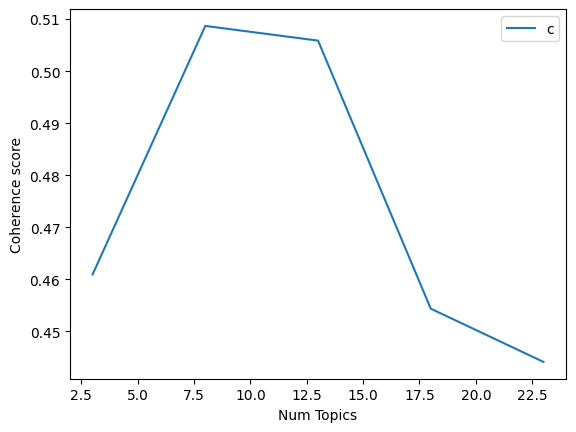

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
limit=25; start=3; step=5
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [83]:
import pprint

optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint.pp(optimal_model.print_topics(num_words=20))

[(0,
  '0.019*"receive" + 0.017*"card" + 0.016*"july" + 0.014*"thank" + '
  '0.014*"wound" + 0.013*"prisoner" + 0.012*"ear" + 0.011*"holzminden" + '
  '0.010*"son" + 0.010*"aug" + 0.009*"love" + 0.008*"dugout" + 0.008*"since" + '
  '0.008*"doctor" + 0.007*"thanks" + 0.007*"heberden" + 0.007*"enclose" + '
  '0.007*"holland" + 0.007*"camp" + 0.007*"address"'),
 (1,
  '0.010*"mrs." + 0.006*"photo" + 0.006*"paper" + 0.006*":" + 0.005*"use" + '
  '0.005*"perhaps" + 0.005*"p.s" + 0.005*"new" + 0.005*"kitchen" + '
  '0.005*"clerk" + 0.005*"month" + 0.005*"price" + 0.005*"business" + '
  '0.004*"mention" + 0.004*"1st" + 0.004*"dream" + 0.004*"builder" + '
  '0.004*"woman" + 0.004*"remember" + 0.004*"list"'),
 (2,
  '0.006*"whole" + 0.005*"order" + 0.005*"pretty" + 0.005*"road" + '
  '0.005*"fire" + 0.005*"however" + 0.005*"platoon" + 0.005*"something" + '
  '0.004*"along" + 0.004*"always" + 0.004*"mile" + 0.004*"number" + '
  '0.004*"except" + 0.004*"although" + 0.004*"company" + 0.004*"play" 

war location descriptions and love
mundane life and errands
movement, and life at the front
war effects, focusing more on impact and destruction, urban bombing
mundane descriptions of time, the weather, daily routine
food rations
military structure
general reflection
travel and love

In [105]:
import pandas as pd

# Assuming you already have:
# - lda_model: your trained gensim LDA model
# - corpus: your documents in Bag-of-Words format
# - original_texts: list of the original text documents (same order as `corpus`)

# Get topic distributions for each document
topic_assignments = []
for doc_bow in enrichedtexts:
    topics = optimal_model.get_document_topics(doc_bow)
    # Get the topic with the highest probability
    dominant_topic = max(topics, key=lambda x: x[1])[0]
    topic_assignments.append(dominant_topic)

# Create a DataFrame
df = pd.DataFrame({
    'Document': original_texts,
    'Dominant_Topic': topic_assignments
})

# (Optional) Preview
print(df.head())


ValueError: too many values to unpack (expected 2)

In [109]:
import numpy as np

docs_id = letterkeys

doc2topics = np.zeros((len(docs_id), optimal_model.num_topics))

for di, doc_topics in enumerate(optimal_model.get_document_topics(bow_corpus, minimum_probability = 0)):
    for ti, v in doc_topics:
        doc2topics[di, ti] = v

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (8).

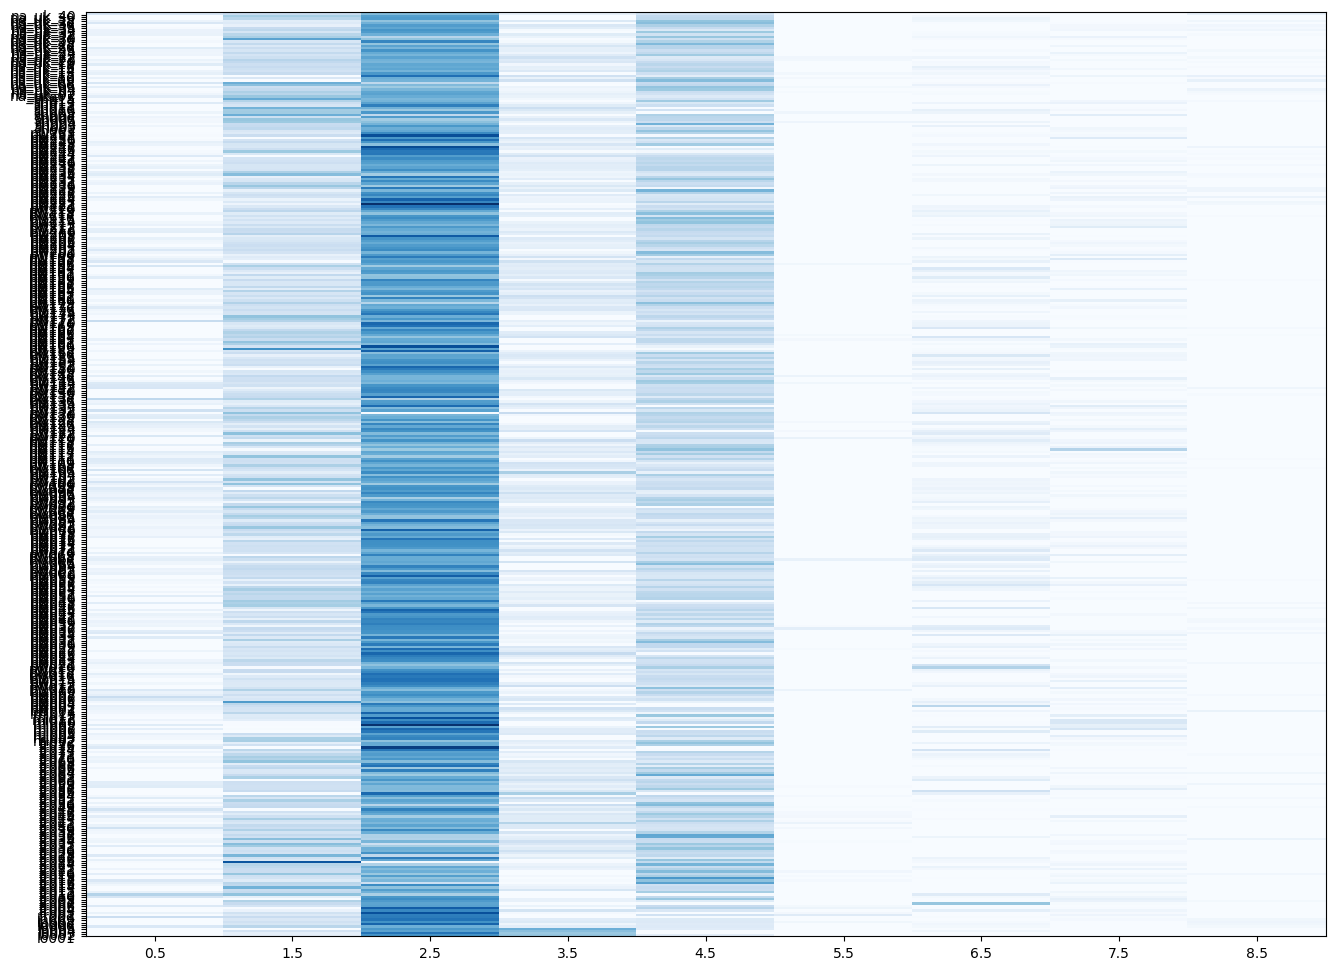

In [110]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics, norm=None, cmap='Blues')
plt.yticks(np.arange(doc2topics.shape[0]), docs_id)
plt.xticks(np.arange(doc2topics.shape[1])+0.5, ["Topic #"+str(n) for n in range(inaug_ldamodel.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.show()

Built 1 of 5.0 models
Built 2 of 5.0 models
Built 3 of 5.0 models
Built 4 of 5.0 models
Built 5 of 5.0 models


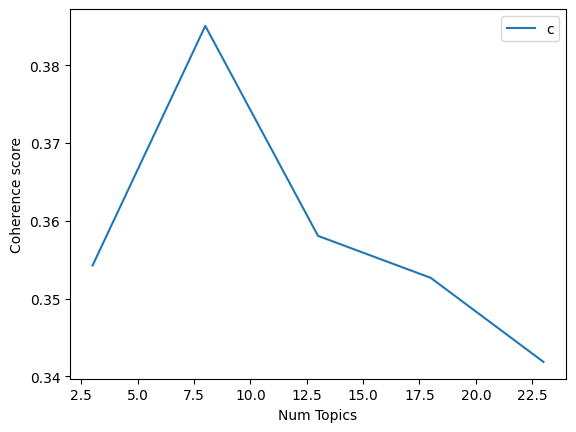

In [ ]:
berttopic